In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
# from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

torch.manual_seed(1); np.random.seed(1)  # for reproducibility

In [7]:
df = pd.read_csv("./data/mpi_roof_2021a.csv",index_col="Date Time", parse_dates=True, encoding="latin", dayfirst=True)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
Date Time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:10:00,978.24,2.01,276.90,-0.82,81.4,7.06,5.75,1.31,3.66,5.88,...,1.02,1.63,210.3,0.0,0.0,0.0,0.0,0.0,13.48,434.7
2021-01-01 00:20:00,978.24,1.96,276.85,-0.79,81.9,7.04,5.77,1.27,3.67,5.89,...,1.56,2.37,199.3,0.0,0.0,0.0,0.0,0.0,13.44,435.4
2021-01-01 00:30:00,978.26,1.88,276.76,-0.77,82.5,7.00,5.77,1.22,3.68,5.90,...,2.08,2.75,207.8,0.0,0.0,0.0,0.0,0.0,13.39,434.2
2021-01-01 00:40:00,978.25,1.78,276.66,-0.71,83.5,6.95,5.80,1.15,3.70,5.93,...,2.63,3.31,206.0,0.0,0.0,0.0,0.0,0.0,13.32,434.3
2021-01-01 00:50:00,978.26,1.62,276.50,-0.44,86.1,6.87,5.91,0.95,3.77,6.04,...,2.16,3.28,192.9,0.0,0.0,0.0,0.0,0.0,13.22,435.8


In [8]:
df.dtypes

p (mbar)                float64
T (degC)                float64
Tpot (K)                float64
Tdew (degC)             float64
rh (%)                  float64
VPmax (mbar)            float64
VPact (mbar)            float64
VPdef (mbar)            float64
sh (g/kg)               float64
H2OC (mmol/mol)         float64
rho (g/m**3)            float64
wv (m/s)                float64
max. wv (m/s)           float64
wd (deg)                float64
rain (mm)               float64
raining (s)             float64
SWDR (W/m²)             float64
PAR (µmol/m²/s)         float64
max. PAR (µmol/m²/s)    float64
Tlog (degC)             float64
CO2 (ppm)               float64
dtype: object

In [9]:
df.index

DatetimeIndex(['2021-01-01 00:10:00', '2021-01-01 00:20:00',
               '2021-01-01 00:30:00', '2021-01-01 00:40:00',
               '2021-01-01 00:50:00', '2021-01-01 01:00:00',
               '2021-01-01 01:10:00', '2021-01-01 01:20:00',
               '2021-01-01 01:30:00', '2021-01-01 01:40:00',
               ...
               '2021-06-30 22:30:00', '2021-06-30 22:40:00',
               '2021-06-30 22:50:00', '2021-06-30 23:00:00',
               '2021-06-30 23:10:00', '2021-06-30 23:20:00',
               '2021-06-30 23:30:00', '2021-06-30 23:40:00',
               '2021-06-30 23:50:00', '2021-07-01 00:00:00'],
              dtype='datetime64[ns]', name='Date Time', length=26064, freq=None)

In [10]:
# check na values
df.isna().sum()

p (mbar)                0
T (degC)                0
Tpot (K)                0
Tdew (degC)             0
rh (%)                  0
VPmax (mbar)            0
VPact (mbar)            0
VPdef (mbar)            0
sh (g/kg)               0
H2OC (mmol/mol)         0
rho (g/m**3)            0
wv (m/s)                0
max. wv (m/s)           0
wd (deg)                0
rain (mm)               0
raining (s)             0
SWDR (W/m²)             0
PAR (µmol/m²/s)         0
max. PAR (µmol/m²/s)    0
Tlog (degC)             0
CO2 (ppm)               0
dtype: int64

In [25]:
# check features variance
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

print(df.shape)
normalized_data = preprocessing.normalize(df)
# normalized_df = pd.DataFrame({df.columns[i]: normalized_data[:,i] for i in range(len(df.columns))})
# normalized_df

selector = VarianceThreshold()
feature_selected = selector.fit_transform(normalized_data)
print(feature_selected.shape)

# all features meet variance threshold, no need to remove

(26064, 21)
(26064, 21)


<AxesSubplot:xlabel='Date Time'>

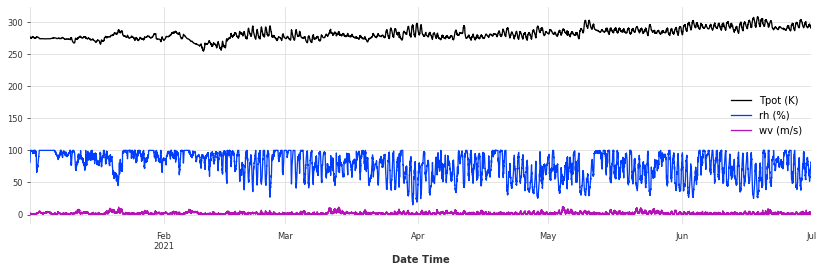

In [63]:
# select Temperature in Kelvin Tpot (K), Relative Humidityrh (%), Wind Speed wv (m/s) for example study

df = df[["Tpot (K)", "rh (%)", "wv (m/s)"]]
df.plot(figsize=(14,4))

In [31]:
# check features correlation
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Tpot (K),rh (%),wv (m/s)
Tpot (K),1.000000,-0.569822,0.160741
rh (%),-0.569822,1.000000,-0.334946
wv (m/s),0.160741,-0.334946,1.000000


## Preprocessing

Usually neural networks tend to work better on normalised/standardised data. Here we’ll use the Scaler class to normalise both of our time series between 0 and 1:

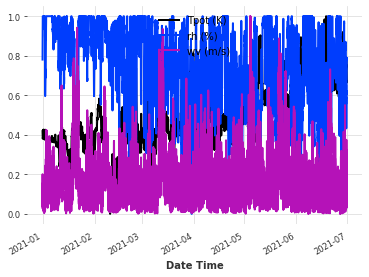

In [34]:
series = TimeSeries.from_dataframe(df)
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

series_scaled.plot()
plt.legend()

## Train / Validation split

Let’s keep the last 1 month of series as validation:

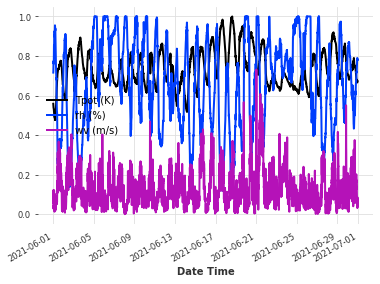

In [37]:
train, val = series_scaled.split_before(pd.Timestamp('20210601'))
val.plot()

* Let the temperature be the **target time series**, which we are interested to forecast (given its history). 
* Humidity and wind speed are **covariate time series**, which may help in the forecasting of the target series. 
* These covariates' past values are known at prediction and their future values are not known, thus called **past covariates**.

In [38]:
# "Tpot (K)", "rh (%)", "wv (m/s)"
train_target = train["Tpot (K)"]
val_target = val["Tpot (K)"]


## Example with One Series


In [53]:
model_t = NBEATSModel(
    input_chunk_length=24*6,
    output_chunk_length=4*6,
    generic_architecture=True,
    num_stacks=4,
    num_blocks=1,
    num_layers=4,
    layer_widths=64,
    n_epochs=40,
    nr_epochs_val_period=1,
    batch_size=16,
    model_name='nbeats_run'
)
model_t.fit(train_target, val_series=val_target, verbose=True)


[2022-01-12 15:55:36,246] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 21576 samples.
[2022-01-12 15:55:36,246] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 21576 samples.
[2022-01-12 15:55:36,252] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-12 15:55:36,252] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/40 [00:00<?, ?it/s]

MAPE = 3.20%


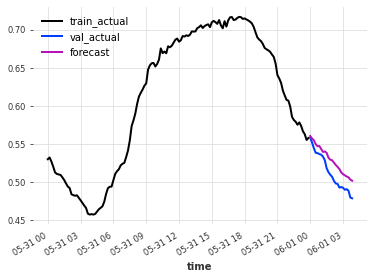

In [55]:
pred = model_t.predict(n=4*6)

train_target[-24*6:].plot(label="train_actual")
val_target[:4*6].plot(label="val_actual")
pred.plot(label="forecast")
plt.legend()
print('MAPE = {:.2f}%'.format(mape(val_target, pred)))

## Training with covariates series

In [56]:
train_cov = train[["rh (%)", "wv (m/s)"]]
val_cov = val[["rh (%)", "wv (m/s)"]]

In [57]:
model_cov = NBEATSModel(
    input_chunk_length=24*6,
    output_chunk_length=4*6,
    generic_architecture=True,
    num_stacks=4,
    num_blocks=1,
    num_layers=4,
    layer_widths=64,
    n_epochs=40,
    nr_epochs_val_period=1,
    batch_size=16,
    model_name='nbeats_run'
)
model_cov.fit(series = train_target,
              past_covariates= train_cov,
              val_series= val_target,
              val_past_covariates= val_cov,
              verbose=True)


[2022-01-12 16:03:52,996] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 21576 samples.
[2022-01-12 16:03:52,996] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 21576 samples.
[2022-01-12 16:03:53,012] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-12 16:03:53,012] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/40 [00:00<?, ?it/s]

Univariate: MAPE = 3.20%
Multivariate: MAPE = 1.99%


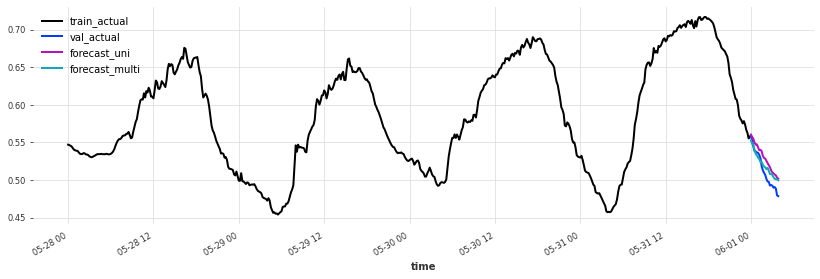

In [62]:
pred_cov = model_cov.predict(n=4*6, 
                             series=train_target, 
                             past_covariates=train_cov)
plt.figure(figsize=(14,4))
train_target[-24*4*6:].plot(label="train_actual")
val_target[:4*6].plot(label="val_actual")
pred.plot(label="forecast_uni")
pred_cov.plot(label="forecast_multi")
plt.legend()
print('Univariate: MAPE = {:.2f}%'.format(mape(val_target, pred)))
print('Multivariate: MAPE = {:.2f}%'.format(mape(val_target, pred_cov)))